# Test validity step 4 : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (S_{approx} + E^t (B^T N^{-1} B)^{-1} E) N_c^{1/2} \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import scipy
import healpy as hp
import astropy.io.fits as fits
import camb
import emcee
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import micmac as micmac
from mcmc_tools import *

from jax import config
config.update("jax_enable_x64", True)

/Users/mag/miniconda3/envs/non_param_silver/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(6, 2, 49152)
(6, 2, 49152)


In [3]:
instrument

,frequency,depth_p,depth_i,fwhm,f_sky,status,reference,type,note,experiment
0,27.0,49.5,35.0,91.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
1,39.0,29.7,21.0,63.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
2,93.0,3.7,2.6,30.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
3,145.0,4.7,3.3,17.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
4,225.0,8.9,6.3,11.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT
5,280.0,22.6,16.0,9.0,0.1,forecast,Journal of Cosmology and Astroparticle Physics...,ground,depth_p is simply depth_i * sqrt(2),SO_SAT


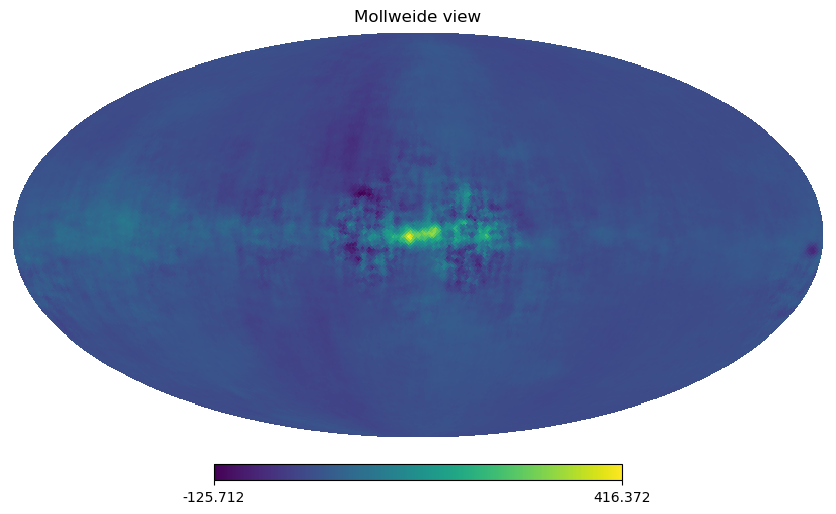

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:
nstokes = 2
nside = 64
lmax = nside*2
lmin = 2

number_frequencies = freq_maps.shape[0]
number_components = 3

limit_iter_cg=2000
tolerance_CG=10**(-12)

n_iter = 8

number_correlations = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

param_dict = {'nside':nside, 'lmax':lmax, 'nstokes':nstokes, 'number_correlations':number_correlations,'number_frequencies':number_frequencies, 'number_components':number_components}
npix = 12*nside**2

In [6]:
all_spectra = generate_power_spectra_CAMB(nside*2, typeless_bool=True)
lensing_spectra = all_spectra['lensed_scalar'][:lmax+1,:]
camb_cls = all_spectra['total'][:lmax+1,:]

c_ells_input = np.zeros((6,lmax+1))
c_ells_input[:4,...] = camb_cls.T
c_ell_approx = np.zeros((6,lmax+1))
c_ell_approx[1] = camb_cls.T[1]
c_ell_approx[2] = lensing_spectra.T[2]


Calculating spectra from CAMB !


In [7]:
indices_polar = np.array([1,2,4])

if nstokes == 2:    
    c_ells_input = c_ells_input[indices_polar,:]
    c_ell_approx = c_ell_approx[indices_polar,:]
    # CMB_map_input = CMB_map_input[1:,:]
    # freq_maps = freq_maps[:,1:,:]

# CMB covariance preparation
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[lmin:,...]
red_cov_matrix = micmac.get_reduced_matrix_from_c_ell(c_ells_input)[lmin:,...]

# Mixing matrix initialization
init_mixing_matrix_obj = micmac.InitMixingMatrix(np.array(instrument['frequency']), number_components, pos_special_freqs=[-1,0])
init_params = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(instrument['frequency'], number_components, init_params, pos_special_freqs=[-1,0])
# mixing_matrix_obj.update_params(mixing_matrix_obj.params/100)
mixing_matrix_sampled = mixing_matrix_obj.get_B()


# Noise initialization
depth_p = instrument['depth_p']
freq_inverse_noise = micmac.get_noise_covar(depth_p, nside)
cp_cp_noise = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

In [8]:
mixing_matrix_obj.params

array([[1.21055502e-02, 1.77190420e+00],
       [5.16775485e-02, 7.56410599e+00],
       [1.29207310e-01, 1.89122320e+01],
       [4.40790072e-01, 6.45189820e+01]])

In [9]:
mixing_matrix_sampled

array([[1.00000000e+00, 0.00000000e+00, 1.00000000e+00],
       [1.00000000e+00, 1.21055502e-02, 1.77190420e+00],
       [1.00000000e+00, 5.16775485e-02, 7.56410599e+00],
       [1.00000000e+00, 1.29207310e-01, 1.89122320e+01],
       [1.00000000e+00, 4.40790072e-01, 6.45189820e+01],
       [1.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

## Sampling $\eta$ : $P(\eta | ...) \propto \eta^t (S_{approx} + E^t (B^t N^{-1} B)^{-1} E) \eta$

In [10]:
%%time
eta_maps = np.zeros((nstokes, npix))
map_random_x = []
map_random_y = []
eta_maps = micmac.get_sampling_eta(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)
eta_prime_maps = get_sampling_eta_prime(param_dict, red_cov_approx_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_x=map_random_x, map_random_y=map_random_y, initial_guess=np.copy(eta_maps), lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)


Recalculating x !
Recalculating y !
CG-Python eta sampling finished in  0 iterations !!
Recalculating x !
Recalculating y !
CPU times: user 479 ms, sys: 131 ms, total: 610 ms
Wall time: 124 ms


## Constrained map realization $s_c$ : $P(s_c | ...) \propto (s_c - s_{c,ML})^t (S_c + E^t (B^t N^{-1} B)^{-1} E)^{-1} (s_c - s_{c,ML})$

In [11]:
s_cML = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0,...]

### Fluctuation part

In [12]:
%%time
initial_guess = np.zeros((nstokes,npix))
map_random_realization_xi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["nstokes"],12*param_dict["nside"]**2))
map_random_realization_chi = np.random.normal(loc=0, scale=1/hp.nside2resol(param_dict["nside"]), size=(param_dict["number_frequencies"],param_dict["nstokes"],12*param_dict["nside"]**2))
fluctuation_maps = micmac.get_fluctuating_term_maps(param_dict, red_cov_matrix, cp_cp_noise, cp_freq_inv_noise_sqrt, map_random_realization_xi=map_random_realization_xi, map_random_realization_chi=map_random_realization_chi, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 Fluct finished in  263 iterations !!
CPU times: user 31.5 s, sys: 3.65 s, total: 35.2 s
Wall time: 5.68 s


### Wiener filter part

In [13]:
%%time
initial_guess = np.zeros((nstokes,npix))
wiener_filter_term = micmac.solve_generalized_wiener_filter_term(param_dict, s_cML, red_cov_matrix, cp_cp_noise, initial_guess=initial_guess, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG)

CG-Python-0 WF finished in  286 iterations !!
CPU times: user 39.4 s, sys: 4.68 s, total: 44.1 s
Wall time: 6.69 s


In [14]:
s_c_map = wiener_filter_term + fluctuation_maps

## Sampling $C$ through inverse Wishart sampling : $P(C | ...) \propto s_c^t C^{-1} s_c + ln|C|$

In [15]:
%%time
c_ells_Wishart = micmac.get_cell_from_map(s_c_map, lmax=lmax, n_iter=n_iter)

red_c_ells_inv_Wishart_sample = np.zeros((lmax+1, nstokes, nstokes))
c_ells_inv_Wishart_sample = np.zeros((number_correlations, lmax+1))

red_c_ells_inv_Wishart_sample = micmac.get_inverse_wishart_sampling_from_c_ells(np.copy(c_ells_Wishart), l_min=lmin)#[lmin:]
c_ells_inv_Wishart_sample = micmac.get_c_ells_from_red_covariance_matrix(red_c_ells_inv_Wishart_sample)


CPU times: user 173 ms, sys: 39.8 ms, total: 213 ms
Wall time: 37.1 ms


## Sampling B_f : $P(B_f | ...) \propto -(d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d-B_c s_c) + \eta^t N_c^{1/2} (S_{approx} + E^t (B^T N^{-1} B)^{-1} E) N_c^{1/2} \eta$

In [16]:
s_c_map_extended = np.zeros((number_components, nstokes, npix))
s_c_map_extended[0,...] = s_c_map

full_current_mixing_matrix = mixing_matrix_obj.get_B()

full_data_without_CMB = freq_maps - np.einsum('fc,csp->fsp',full_current_mixing_matrix, s_c_map_extended)

In [17]:
first_residual = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]

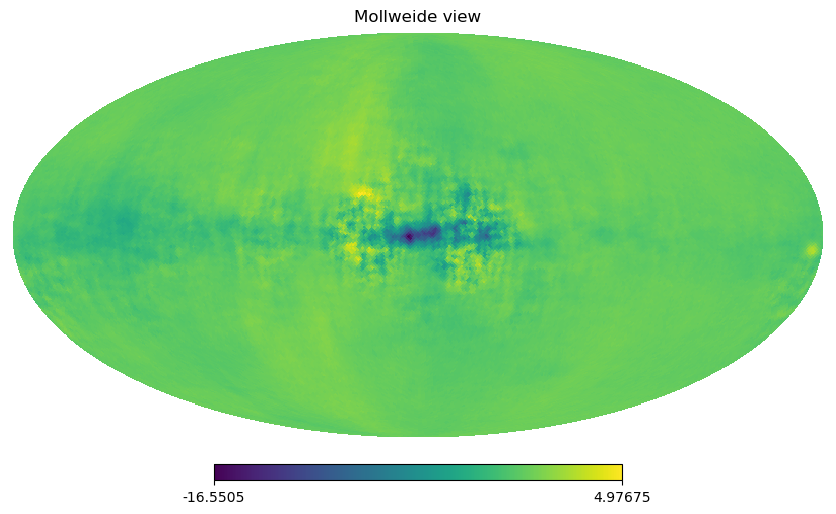

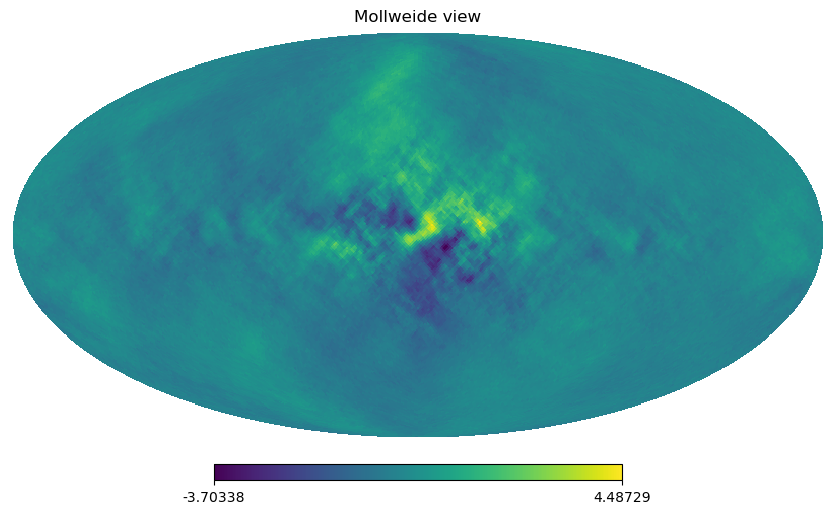

In [18]:
hp.mollview(first_residual[0])
hp.mollview(first_residual[1])

In [19]:
full_data_without_CMB.shape

(6, 2, 49152)

In [20]:
freq_maps.shape

(6, 2, 49152)

In [21]:
complete_mixing_matrix_fg = mixing_matrix_obj.get_B_fgs()
cp_freq_inv_noise_fg = micmac.get_BtinvN(freq_inverse_noise, complete_mixing_matrix_fg)
cp_cp_noise_fg = micmac.get_inv_BtinvNB(freq_inverse_noise, complete_mixing_matrix_fg)
print(cp_freq_inv_noise_fg, cp_freq_inv_noise_fg.shape, full_data_without_CMB.shape)

map_fgs = np.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
print('d-Bcsc -- mean', np.mean(full_data_without_CMB), 'max', np.max(full_data_without_CMB), 'min', np.min(full_data_without_CMB))
print('B_fN^{-1} (d-Bcsc) - mean', np.mean(map_fgs), 'max', np.max(map_fgs), 'min', np.min(map_fgs))
print('B_fN^{-1} - mean', np.mean(cp_freq_inv_noise_fg), 'max', np.max(cp_freq_inv_noise_fg), 'min', np.min(cp_freq_inv_noise_fg))
print('(B_f^t N^{-1} B_f)^{-1} - mean', np.mean(cp_cp_noise_fg), 'max', np.max(cp_cp_noise_fg), 'min', np.min(cp_cp_noise_fg))

[[0.00000000e+00 4.14656112e-02 1.14055148e+01 1.76728994e+01
  1.68138910e+01 5.91561031e+00]
 [1.23312198e+00 6.06937224e+00 1.66943915e+03 2.58680390e+03
  2.46106979e+03 0.00000000e+00]] (2, 6) (6, 2, 49152)
d-Bcsc -- mean 4.052183932089798 max 555.9755079478549 min -316.14231386359387
B_fN^{-1} (d-Bcsc) - mean 8887.07378862576 max 853551.52884099 min -476635.09498959716
B_fN^{-1} - mean 564.7053926654136 max 2586.8039034954245 min 0.0
(B_f^t N^{-1} B_f)^{-1} - mean 0.04168632064891228 max 0.16904262077299984 min -0.0011548832558952995


In [22]:
np.log(np.linalg.det(cp_cp_noise))

-19.353983849099905

In [23]:
%%time

# Calculation value log_proba with current value of B_f

regularization_constant = -1
regularization_factor = 10**10
# log_proba = micmac.get_conditional_proba_mixing_matrix_foregrounds(mixing_matrix_obj.params, mixing_matrix_obj, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True)
log_proba = micmac.get_conditional_proba_mixing_matrix_foregrounds(mixing_matrix_obj.params, mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=True, regularization_constant=regularization_constant, regularization_factor=regularization_factor)
print("Log_proba :", log_proba)
print("<-> Proba :", np.exp(log_proba))

CG-Python-0 WF finished in  17 iterations !!
Log_proba : -0.7767816720659966
<-> Proba : 0.4598836887263465
CPU times: user 2.36 s, sys: 283 ms, total: 2.64 s
Wall time: 468 ms


In [24]:
mixing_matrix_obj.params.shape

(4, 2)

In [25]:
# ver = '0a'
# filename_backend_mcmc = "validation_step_4_SO_{}ver{}.h5".format(nside,ver)
# ver = '0b'
# filename_backend_mcmc = "validation_step_4_ver{}.h5".format(ver)
# ver = '0c'
# filename_backend_mcmc = "validation_step_4_ver{}.h5".format(ver)

ver = '1c'
filename_backend_mcmc = "test_numpyro_step_4_ver{}.h5".format(ver)


In [26]:
from functools import partial

# @partial(jax.jit, static_argnums=(1,2,3,4))
def maps_x_red_covariance_cell_JAX(maps_TQU_input, red_matrix_sqrt, nside, lmin=0, n_iter=8, all_params=3):
    # if lmax == -1:
    lmax = red_matrix_sqrt.shape[0] - 1 + lmin
    # lmax = jnp.size(red_matrix_sqrt) - 1 + lmin
    nstokes = red_matrix_sqrt.shape[1]
    # print('Test size :', lmax, '---', jnp.size(red_matrix_sqrt)/(nstokes**2), '---', lmin, flush=True)
    # all_params = jnp.int16(jnp.where(nstokes > 1, 3, 1))

    # if jnp.size(maps_TQU_input.shape) == 1:
    #     nside = jnp.int64(np.sqrt(jnp.size(maps_TQU_input)/12))
    # else:
    #     nside = jnp.int64(np.sqrt(jnp.size(maps_TQU_input[0])/12))
    
    # red_sqrt_decomp = np.zeros_like(red_matrix)
    red_sqrt_decomp = jnp.zeros((lmax+1,all_params,all_params))
    if nstokes != 1:
        # red_sqrt_decomp[lmin:,3-nstokes:,3-nstokes:] = red_matrix_sqrt
        red_sqrt_decomp = red_sqrt_decomp.at[lmin:,3-nstokes:,3-nstokes:].set(red_matrix_sqrt)
    else:
        # red_sqrt_decomp[lmin:,...] = red_matrix_sqrt
        red_sqrt_decomp = red_sqrt_decomp.at[lmin:].set(red_matrix_sqrt)

    if maps_TQU_input.shape[0] == 2:
        maps_TQU = jnp.vstack((jnp.zeros_like(maps_TQU_input[0]),jnp.copy(maps_TQU_input)))
    else:
        maps_TQU = jnp.copy(maps_TQU_input)

    def wrapper_map2alm(maps_, lmax=lmax, n_iter=n_iter, nside=nside):
        alm_T, alm_E, alm_B = hp.map2alm(maps_.reshape((3, 12*nside**2)), lmax=lmax, iter=n_iter)
        return np.array([alm_T, alm_E, alm_B])
    
    def wrapper_almxfl(alm_, matrix_ell):
        return hp.almxfl(alm_, matrix_ell, inplace=False)
    
    def wrapper_alm2map(alm_, lmax=lmax, nside=nside):
        return hp.alm2map(alm_, nside, lmax=lmax)

    @partial(jax.jit, static_argnums=(1,2))
    def pure_call_map2alm(maps_, lmax, nside):
        # if jnp.size(maps_TQU_input.shape) == 1:
        #     nside = jnp.int64(np.sqrt(jnp.size(maps_TQU_input)/12))
        # else:
        #     nside = jnp.int64(np.sqrt(jnp.size(maps_TQU_input[0])/12))
        shape_output = (3,(lmax+1)*(nside+1))
        return jax.pure_callback(wrapper_map2alm, jax.ShapeDtypeStruct(shape_output, np.complex128), maps_.ravel())
    
    # @partial(jax.jit, static_argnames=['matrix_ell'])
    def pure_call_almxfl(alm_, matrix_ell):
        shape_output = [(lmax+1)*(nside+1)]
        return jax.pure_callback(wrapper_almxfl, jax.ShapeDtypeStruct(shape_output, np.complex128), alm_, matrix_ell)

    @partial(jax.jit, static_argnums=(1,2))
    def pure_call_alm2map(alm_, lmax, nside):
        # if jnp.size(maps_TQU_input.shape) == 1:
        #     nside = jnp.int64(np.sqrt(jnp.size(maps_TQU_input)/12))
        # else:
        #     nside = jnp.int64(np.sqrt(jnp.size(maps_TQU_input[0])/12))
        shape_output = (3,12*nside**2)
        return jax.pure_callback(wrapper_alm2map, jax.ShapeDtypeStruct(shape_output, np.float64), alm_)

    # alms_input = hp.map2alm(maps_TQU, lmax=lmax, iter=n_iter)
    alms_input = pure_call_map2alm(maps_TQU, lmax=lmax, nside=nside)
    # alms_input = hp.map2alm(maps_TQU, lmax=lmax, iter=n_iter)
    alms_output = jnp.zeros_like(alms_input)

    for i in range(all_params):
        alms_j = jnp.zeros_like(alms_input[i])
        for j in range(all_params):
            # alms_j += hp.almxfl(alms_input[j], red_sqrt_decomp[:,i,j], inplace=False)
            result_callback = pure_call_almxfl(alms_input[j], red_sqrt_decomp[:,i,j])
            alms_j += result_callback
        # alms_output[i] = jnp.copy(alms_j)
        alms_output = alms_output.at[i,...].set(jnp.copy(alms_j))
    # maps_output = hp.alm2map(alms_output, nside, lmax=lmax)
    maps_output = pure_call_alm2map(alms_output, nside=nside, lmax=lmax)
    if nstokes != 1:
        return maps_output[3-nstokes:,...]
    return maps_output

# @partial(jax.jit, static_argnames=['number_components', 'nstokes', 'nside', 'right_member', 'operator_harmonic', 'operator_pixel', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints'])
def get_inverse_operators_harm_pixel_JAX(number_components, nstokes, nside, right_member, operator_harmonic, operator_pixel, initial_guess=[], lmin=2, n_iter=8, limit_iter_cg=1000, tolerance=10**(-12), with_prints=False):
    """ Solve the CG given by :
        (operator_harmonic + operator_pixel) variable = right_member

        with operator_harmonic an operator acting on harmonic domain
        with operator_pixel an operator acting on (component,pixel_domain) domain, in CMB component

        Returns
        -------
        A pixel map
        
    """

    # print("Test 2 :", lmin, flush=True)
    # first_term_left = lambda x : maps_x_reduced_matrix_generalized_sqrt_sqrt(x.reshape((param_dict["nstokes"],12*param_dict["nside"]**2)), operator_harmonic, lmin=lmin, n_iter=n_iter)
    first_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((nstokes,12*nside**2)), operator_harmonic, nside=nside, lmin=lmin, n_iter=n_iter, all_params=3)
    ## Second left member : (E^t (B^t N^{-1} B)^{-1}
    # @partial(jax.jit, static_argnames=['operator_pixel','param_dict'])
    def second_term_left(x, operator_pixel=operator_pixel):
        cg_variable = x.reshape((nstokes,12*nside**2))
        x_all_components = jnp.zeros((number_components, cg_variable.shape[0], cg_variable.shape[1]))
        x_all_components = x_all_components.at[0].set(cg_variable)
        return jnp.einsum('kc,csp->ksp', operator_pixel, x_all_components)[0]

    func_left_term = lambda x : (first_term_left(x) + second_term_left(x)).ravel()

    if len(initial_guess) == 0:
        initial_guess = jnp.zeros((nstokes,12*nside**2))
    # inverse_term, number_iterations, exit_code = generalized_cg_from_func(initial_guess.ravel(), func_left_term, right_member.ravel(), limit_iter_cg=limit_iter_cg, tolerance=tolerance)
    inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=tolerance, atol=tolerance, maxiter=limit_iter_cg)
    if with_prints:
        print("CG-Python-0 WF finished in ", number_iterations, "iterations !!")
        # if exit_code != 0:
        #     print("CG didn't converge with WF ! Exitcode :", exit_code, flush=True)
    return inverse_term.reshape((nstokes, 12*nside**2))

def get_inv_BtinvNB_jax(invN, B):
    """
    B can be full Mixing Matrix, 
    or just the cmb part, 
    or just the fgs part.
    """
    BtinvNB = jnp.einsum('fc,fh,hg->cg', B, invN, B)
    invBtinvNB = jnp.linalg.inv(BtinvNB)
    
    return invBtinvNB


def get_BtinvN_jax(invN, B):
    """
    B can be full Mixing Matrix, 
    or just the cmb part, 
    or just the fgs part.
    """
    BtinvN = jnp.einsum('fc,fh->ch', B, invN)
    
    return BtinvN

@partial(jax.jit, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints', 'regularization_constant', 'regularization_factor'])
def get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(complete_mixing_matrix, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, number_components, nstokes, nside, lmin, n_iter, limit_iter_cg, tolerance, with_prints=False, regularization_constant=-1, regularization_factor=10**10):
    """ Get conditional probability of mixing matrix by sampling it using emcee

        The associated conditional probability is given by : 
        - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
        + \eta^t N_c^{1/2} (C_{approx} + E^t (B^T N^{-1} B)^{-1} E)^{-1} N_c^{1/2} \ \eta 
    """

    # print("Test params :", params_mixing_matrix.reshape((param_dict['number_frequencies']-2,param_dict['number_components']-1)))
    # mixingmatrix_object = mixing_matrix_obj
    # mixingmatrix_object.update_params(params_mixing_matrix.reshape((param_dict['number_frequencies']-2,param_dict['number_components']-1)))
    # mixingmatrix_object = micmac.MixingMatrix(frequency_list, param_dict['number_components'], params_mixing_matrix, pos_special_freqs=pos_special_freqs)

    # Building the first term : - (d - B_c s_c)^t N^{-1} B_f (B_f^t N^{-1} B_f)^{-1} B_f^t N^{-1} (d - B_c s_c)
    # complete_mixing_matrix_fg = mixingmatrix_object.get_B_fgs()
    complete_mixing_matrix_fg = complete_mixing_matrix[:,1:]

    cp_cp_noise_fg = get_inv_BtinvNB_jax(freq_inverse_noise, complete_mixing_matrix_fg)
    cp_freq_inv_noise_fg = get_BtinvN_jax(freq_inverse_noise, complete_mixing_matrix_fg)

    full_data_without_CMB_with_noise = jnp.einsum('cf,fsp->csp', cp_freq_inv_noise_fg, full_data_without_CMB)
    # print("Test 1 :", np.mean(full_data_without_CMB_with_noise), np.max(full_data_without_CMB_with_noise), np.min(full_data_without_CMB_with_noise), full_data_without_CMB_with_noise)
    first_term_complete = jnp.einsum('psc,cm,msp', full_data_without_CMB_with_noise.T, cp_cp_noise_fg, full_data_without_CMB_with_noise)
    # print("Test 2 :", np.mean(cp_cp_noise_fg), np.max(cp_cp_noise_fg), np.min(cp_cp_noise_fg), cp_cp_noise_fg)

    # Building the second term term \eta^t N_c^{1/2] (C_approx + E^t (B^t N^{-1} B)^{-1} E)^{-1} N_c^{1/2] \eta
    # complete_mixing_matrix = mixingmatrix_object.get_B()
    cp_cp_noise = get_inv_BtinvNB_jax(freq_inverse_noise, complete_mixing_matrix)

    ## Left hand side term : N_c^{1/2] \eta = (E^t (B^t N^{-1} B)^{-1} B^t N^{-1/2} \eta
    # noise_weighted_eta = np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise_sqrt, eta_maps)[0] # Selecting CMB component
    # eta_prime_maps_extended = jnp.array(np.zeros((param_dict['number_components'],param_dict['nstokes'],12*param_dict['nside']**2)))
    eta_prime_maps_extended = jnp.array(np.zeros((number_components,nstokes,12*nside**2)))
    # eta_prime_maps_extended[0] = eta_prime_maps
    eta_prime_maps_extended = eta_prime_maps_extended.at[0].set(eta_prime_maps)
    noise_weighted_eta = jnp.einsum('kc,csp->ksp', cp_cp_noise, eta_prime_maps_extended)[0] # Selecting CMB component

    # Then getting (C_approx + E^t (B^t N^{-1} B)^{-1} E)^{-1} N_c^{1/2] \eta
    operator_harmonic = red_cov_approx_matrix
    operator_pixel = cp_cp_noise
    # print("Test 3 :", lmin, flush=True)
    inverse_term = get_inverse_operators_harm_pixel_JAX(number_components, nstokes, nside, noise_weighted_eta, operator_harmonic, operator_pixel, initial_guess=[], lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance, with_prints=with_prints)

    # And finally \eta^t N_c^{1/2] (C_approx + E^t (B^t N^{-1} B)^{-1} E)^{-1} N_c^{1/2] \eta
    # second_term_complete = np.einsum('fsk,fsk', noise_weighted_eta, inverse_term)
    second_term_complete = jnp.einsum('sk,sk', noise_weighted_eta, inverse_term)
    # print("Test", first_term_complete, second_term_complete)
    return -(-first_term_complete + second_term_complete)/2./regularization_factor + regularization_constant


In [27]:
jitted_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX = jax.jit(get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX, static_argnames=['number_components', 'nstokes', 'nside', 'lmin', 'n_iter', 'limit_iter_cg', 'tolerance', 'with_prints', 'regularization_constant', 'regularization_factor'])

mixingmatrix_object = mixing_matrix_obj


def new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(params_mixing_matrix, **model_kwargs):
    
    # mixingmatrix_object = model_kwargs['mixingmatrix_object']
    # full_data_without_CMB = model_kwargs['full_data_without_CMB']
    # eta_prime_maps = model_kwargs['eta_prime_maps']
    # freq_inverse_noise = model_kwargs['freq_inverse_noise']
    # red_cov_approx_matrix = model_kwargs['red_cov_approx_matrix']
    # # param_dict = model_kwargs['param_dict']
    # lmin = model_kwargs['lmin']
    # print("lmin test --", lmin, flush=True)
    # n_iter = model_kwargs['n_iter']
    # limit_iter_cg = model_kwargs['limit_iter_cg']
    # tolerance = model_kwargs['tolerance']
    # try :
    #     with_prints = model_kwargs['with_prints']
    # except :
    #     with_prints =False
    # try :
    #     regularization_constant = model_kwargs['regularization_constant']
    #     regularization_factor = model_kwargs['regularization_factor']
    # except:
    #     regularization_constant = -1
    #     regularization_factor = 10**10

    # mixingmatrix_object.update_params(params_mixing_matrix.reshape((param_dict['number_frequencies']-2,param_dict['number_components']-1)))
    # return jitted_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(np.copy(mixingmatrix_object.get_B()), jnp.array(full_data_without_CMB), jnp.array(eta_prime_maps), freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints, regularization_constant=regularization_constant, regularization_factor=regularization_factor)
    new_mixing_matrix = jnp.ones((param_dict['number_frequencies'],param_dict['number_components']))
    # new_mixing_matrix[0,1] = 0
    # new_mixing_matrix[-1,-1] = 0
    # new_mixing_matrix[1:,1:-1] = jnp.array(params_mixing_matrix.reshape((param_dict['number_frequencies']-2,param_dict['number_components']-1)))
    new_mixing_matrix = new_mixing_matrix.at[0,1].set(0)
    new_mixing_matrix = new_mixing_matrix.at[-1,-1].set(0)
    new_mixing_matrix = new_mixing_matrix.at[1:-1,1:].set(jnp.array(params_mixing_matrix.reshape((param_dict['number_frequencies']-2,param_dict['number_components']-1))))
    return get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(jnp.copy(new_mixing_matrix), jnp.array(full_data_without_CMB), jnp.array(eta_prime_maps), freq_inverse_noise, red_cov_approx_matrix, param_dict['number_components'], param_dict['nstokes'], param_dict['nside'], lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints, regularization_constant=regularization_constant, regularization_factor=regularization_factor)

    

In [28]:
jitted_new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX = jax.jit(new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX)

In [29]:
initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)
full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.95,high=initial_guess_fg_mixing_matrix*1.05, size=(dimensions_mixing_matrix))
# full_initial_guess[0] = np.copy(initial_guess_fg_mixing_matrix)

In [30]:

# # dict_params = {'mixingmatrix_object':mixing_matrix_obj, 'full_data_without_CMB':full_data_without_CMB, 'eta_prime_maps':eta_prime_maps, 'freq_inverse_noise':freq_inverse_noise, 'red_cov_approx_matrix':red_cov_approx_matrix, 'param_dict':param_dict, 'lmin':lmin, 'n_iter':n_iter, 'limit_iter_cg':limit_iter_cg, 'tolerance':tolerance_CG, 'with_prints':True}
# dict_params = {'full_data_without_CMB':full_data_without_CMB, 'eta_prime_maps':eta_prime_maps, 'freq_inverse_noise':freq_inverse_noise, 'red_cov_approx_matrix':red_cov_approx_matrix, 'param_dict':param_dict, 'lmin':lmin, 'n_iter':n_iter, 'limit_iter_cg':limit_iter_cg, 'tolerance':tolerance_CG, 'with_prints':True}
# jitted_new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(full_initial_guess, model_kwargs=dict_params)

In [59]:

with_prints = False

number_steps_sampler = 700
n_walkers = 1

# kernel = MetropolisHastings(new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX, step_size=0.5)
kernel = MetropolisHastings(new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX, step_size=5)
mcmc = MCMC(kernel, num_warmup=0, num_samples=number_steps_sampler)


In [60]:
initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)
full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.95,high=initial_guess_fg_mixing_matrix*1.05, size=(n_walkers,dimensions_mixing_matrix))
# full_initial_guess[0] = np.copy(initial_guess_fg_mixing_matrix)

In [61]:
mixing_matrix_obj.params

array([[1.21055502e-02, 1.77190420e+00],
       [5.16775485e-02, 7.56410599e+00],
       [1.29207310e-01, 1.89122320e+01],
       [4.40790072e-01, 6.45189820e+01]])

In [62]:
initial_guess_fg_mixing_matrix = np.array(mixing_matrix_obj.params).ravel()
dimensions_mixing_matrix = jnp.size(initial_guess_fg_mixing_matrix)
full_initial_guess = jnp.array(np.random.uniform(low=initial_guess_fg_mixing_matrix*.95,high=initial_guess_fg_mixing_matrix*1.05, size=(n_walkers,dimensions_mixing_matrix)))
# full_initial_guess[0] = np.copy(initial_guess_fg_mixing_matrix)
print(full_initial_guess)

[[1.20826957e-02 1.81308776e+00 5.35558662e-02 7.60658727e+00
  1.23481065e-01 1.88545935e+01 4.34722901e-01 6.33335701e+01]]


In [63]:
# mcmc.run(random.PRNGKey(0), init_params=full_initial_guess, full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=eta_prime_maps, freq_inverse_noise=freq_inverse_noise, red_cov_approx_matrix=red_cov_approx_matrix, param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints)
mcmc.run(random.PRNGKey(0), init_params=full_initial_guess, full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=jnp.array(eta_prime_maps), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints)
samples = mcmc.get_samples()
mcmc.print_summary()


sample: 100%|██████████| 700/700 [06:15<00:00,  1.86it/s]


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0,0]    -41.16     26.80    -40.92    -83.02      2.35     11.38      1.22
Param:0[0,1]    -11.29     46.79    -14.02    -77.80     59.63      3.08      1.79
Param:0[0,2]     -7.82     31.07     -9.67    -63.68     38.03      7.70      1.05
Param:0[0,3]     75.10     40.62     62.14     26.34    160.36      5.70      1.32
Param:0[0,4]    -40.84     67.14    -33.33   -172.35     43.13      3.66      1.75
Param:0[0,5]     34.14     38.93     31.45    -24.47    104.36      5.35      1.03
Param:0[0,6]    -20.09     31.55    -16.94    -69.69     28.77      7.27      1.00
Param:0[0,7]     44.53     30.86     51.06    -12.68     83.64      5.53      1.34



In [64]:
samples.shape

(700, 1, 8)

In [65]:
# %%time
# log_proba_samples = np.array([new_get_conditional_proba_mixing_matrix_foregrounds_alternative_JAX(samples[i], full_data_without_CMB=jnp.array(full_data_without_CMB), eta_prime_maps=jnp.array(eta_prime_maps), freq_inverse_noise=jnp.array(freq_inverse_noise), red_cov_approx_matrix=jnp.array(red_cov_approx_matrix), param_dict=param_dict, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=tolerance_CG, with_prints=with_prints) for i in range(number_steps_sampler)])

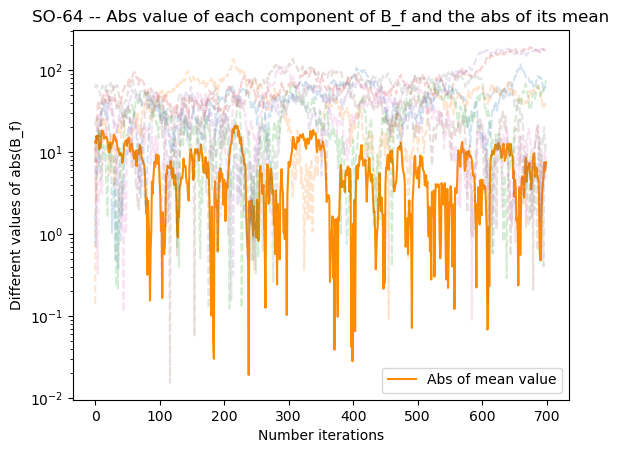

In [102]:
plt.plot(np.arange(number_steps_sampler), np.abs(samples.mean(axis=(2))), color='darkorange', label='Abs of mean value')
plt.plot(np.arange(number_steps_sampler), np.abs(samples[:,0,:]), '--', alpha=.2)
# plt.plot(np.arange(number_steps_sampler), np.abs(samples.mean(axis=(1,2))))
plt.yscale('log')
plt.title(f"SO-{nside} -- Abs value of each component of B_f and the abs of its mean")
plt.xlabel('Number iterations')
plt.ylabel('Different values of abs(B_f)')
plt.legend()
plt.show()

In [67]:
autocorrelation = numpyro.diagnostics.autocorrelation(samples)
autocovariance = numpyro.diagnostics.autocovariance(samples)



In [68]:
autocorrelation.shape

(700, 1, 8)

In [69]:
autocovariance.shape

(700, 1, 8)

In [87]:
dist.Normal(np.array([3,2]),np.array([4,5])).sample(random.PRNGKey(0))

Array([10.26434669, -1.77442422], dtype=float64)

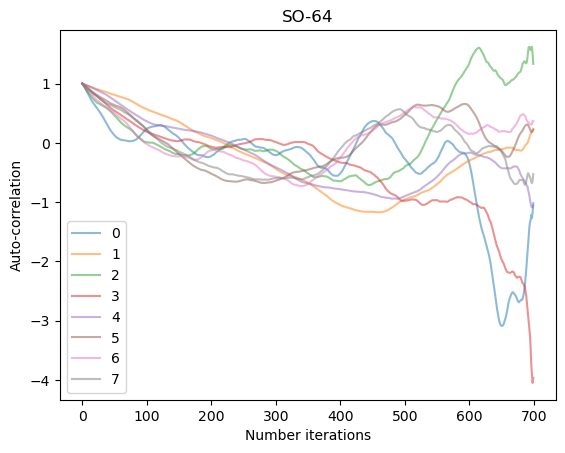

In [79]:

plt.plot(np.arange(number_steps_sampler), autocorrelation[:,0,:], alpha=.5)
# plt.plot(np.arange(number_steps_sampler), np.mean(autocorrelation[:,0,:],axis=1), 'k')
# plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Auto-correlation')
plt.legend([f"{i}" for i in range(8)])
plt.show()

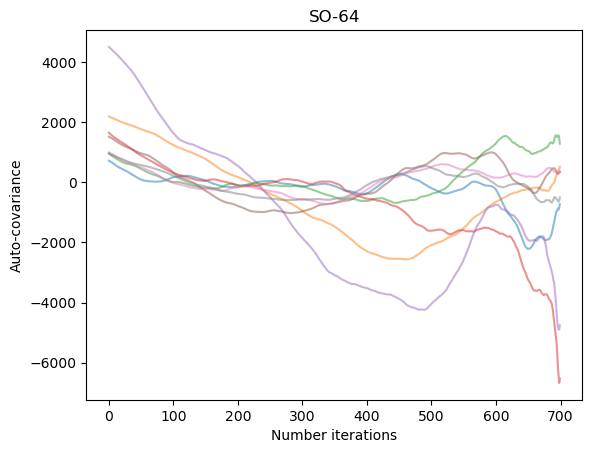

In [71]:

plt.plot(np.arange(number_steps_sampler), autocovariance[:,0,:], alpha=.5)
# plt.plot(np.arange(number_steps_sampler), np.mean(autocorrelation[:,0,:],axis=1), 'k')
# plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Auto-covariance')
plt.show()

In [72]:
autocorrelation_times = np.array([1 + 2*(autocorrelation[i*100:(i+1)*100]/autocorrelation[i*100]).sum(axis=0) for i in range(7)])

In [73]:
autocorrelation_times

array([[[   64.71906086,   161.43570566,    92.76516274,   113.78053897,
           142.06396932,   127.16475423,    98.22867632,   123.3904111 ]],

       [[   41.52533154,   118.18686487, -2640.13644642,    59.61223021,
           132.72129714,  -168.46303315,  1923.85624415,  -121.70664671]],

       [[   53.20917116,  -413.94864952,   202.28685152,    33.03665599,
          -199.50695587,   243.75722596,   493.16513314,   274.44095109]],

       [[  260.9721723 ,   326.32016483,   682.06823967, -1466.20621501,
           314.64853941,   141.10419341,   201.60624798,   169.29131229]],

       [[  -16.08499388,   213.31708425,   184.15077082,   358.4422076 ,
           222.978319  ,  -103.72144561,  -158.62184604,  -572.45024858]],

       [[  196.19675935,   140.49311601,  -193.74468641,   200.31273541,
           121.36136087,   255.2563778 ,   167.78664529,    97.56655269]],

       [[ 1183.66233629,    81.42488892,   193.22109023,   379.51837779,
           501.24306439,    34.75

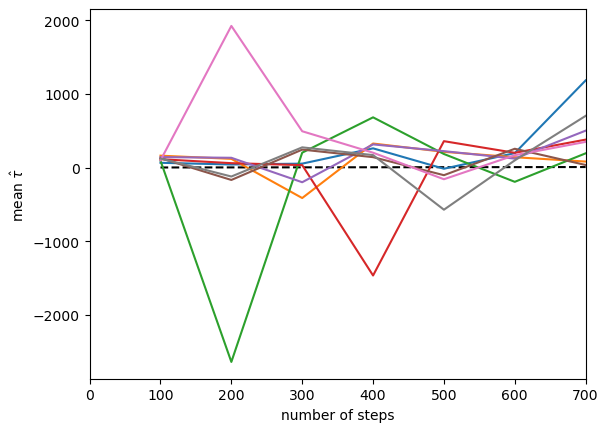

In [74]:
index = int(number_steps_sampler/100)
time_array = 100 * np.arange(1, index + 1)
plt.plot(time_array, time_array / 100.0, "--k")
# plt.plot(time_array, autocorrelation_times[:index])
plt.plot(time_array, autocorrelation_times[:,0,:])
plt.xlim(0, time_array.max())
# plt.ylim(0, autocorr[:index].max() + 0.1 * (autocorr.max() - autocorr.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

In [75]:
import emcee.autocorr

In [76]:
# https://github.com/dfm/emcee/blob/59b6a34323022bc547c3a9fb2173cbffe806af9b/src/emcee/backends/backend.py#L130
emcee.autocorr.integrated_time(samples, tol=0)

array([60.81816201, 85.63988695, 57.36778027, 89.05231003, 82.05871064,
       49.71842023, 49.38673751, 52.09183445])

In [77]:
log_prob_samples_reshape = log_prob_samples.reshape((n_walkers, int((number_steps_sampler-burnin)/thin)))

plt.plot(np.arange(int((number_steps_sampler-burnin)/thin)), np.exp(log_prob_samples_reshape.T), alpha=.2)
plt.plot(np.arange(int((number_steps_sampler-burnin)/thin)), np.mean(np.exp(log_prob_samples_reshape.T),axis=1))
plt.plot(np.arange(int((number_steps_sampler-burnin)/thin)), np.exp(log_prob_samples_reshape)[0])
plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Probability')
plt.show()

NameError: name 'log_prob_samples' is not defined

In [ ]:
# %%time


# # And now sampling B_f using emcee

# n_walkers = 20
# # We have 6*3 parameters to sample, trying to go with 100 steps first
# # number_steps_sampler = 1000
# number_steps_sampler = 700
# with_prints = False

# # whole_chain_samples = micmac.sample_mixing_matrix_term(param_dict, mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, red_cov_approx_matrix, freq_inverse_noise, lmin=lmin, n_iter=n_iter, limit_iter_cg=limit_iter_cg, tolerance=10**(-12), n_walkers=n_walkers, number_steps_sampler=number_steps_sampler, with_prints=with_prints)

# initial_guess_fg_mixing_matrix = mixing_matrix_obj.params.ravel()
# dimensions_mixing_matrix = len(initial_guess_fg_mixing_matrix)

# backend = emcee.backends.HDFBackend(filename_backend_mcmc)
# backend.reset(n_walkers, dimensions_mixing_matrix) # To reset the file !

# # sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixingmatrix_object, full_data_without_CMB, eta_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance, with_prints])
# sample_params_mixing_matrix_FG = emcee.EnsembleSampler(n_walkers, dimensions_mixing_matrix, get_conditional_proba_mixing_matrix_foregrounds, args=[mixing_matrix_obj, full_data_without_CMB, eta_prime_maps, freq_inverse_noise, red_cov_approx_matrix, param_dict, lmin, n_iter, limit_iter_cg, tolerance_CG, with_prints], backend=backend)

# # We'll track how the average autocorrelation time estimate changes
# index = 0
# autocorr = np.empty(number_steps_sampler)

# # This will be useful to testing convergence
# old_tau = np.inf

# # Initial guess
# # full_initial_guess = np.random.randn(n_walkers,dimensions_mixing_matrix)
# full_initial_guess = np.random.uniform(low=initial_guess_fg_mixing_matrix*.05,high=initial_guess_fg_mixing_matrix*1.05, size=(n_walkers,dimensions_mixing_matrix))
# full_initial_guess[0] = np.copy(initial_guess_fg_mixing_matrix)

# # final_position_walkers = sample_params_mixing_matrix_FG.run_mcmc(full_initial_guess, number_steps_sampler)

# # Now we'll sample for up to number_steps_sampler steps
# for sample in sample_params_mixing_matrix_FG.sample(full_initial_guess, iterations=number_steps_sampler, progress=True):
#     # Only check convergence every 100 steps
#     if sample_params_mixing_matrix_FG.iteration % 100:
#         continue

#     # Compute the autocorrelation time so far
#     # Using tol=0 means that we'll always get an estimate even
#     # if it isn't trustworthy
#     tau = sample_params_mixing_matrix_FG.get_autocorr_time(tol=0)
#     autocorr[index] = np.mean(tau)
#     index += 1

#     # Check convergence
#     converged = np.all(tau * 100 < sample_params_mixing_matrix_FG.iteration)
#     converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
#     if converged:
#         break
#     old_tau = tau


In [ ]:
time_array = 100 * np.arange(1, index + 1)
plt.plot(time_array, time_array / 100.0, "--k")
plt.plot(time_array, autocorr[:index])
plt.xlim(0, time_array.max())
# plt.ylim(0, autocorr[:index].max() + 0.1 * (autocorr.max() - autocorr.min()))
plt.xlabel("number of steps")
plt.ylabel(r"mean $\hat{\tau}$");

NameError: name 'index' is not defined

In [ ]:
tau = sample_params_mixing_matrix_FG.get_autocorr_time()
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))
samples = sample_params_mixing_matrix_FG.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sample_params_mixing_matrix_FG.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = sample_params_mixing_matrix_FG.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))


burn-in: 10
thin: 2
flat chain shape: (6900, 8)
flat log prob shape: (6900,)


AttributeError: 'NoneType' object has no attribute 'shape'

In [ ]:
whole_chain_samples = sample_params_mixing_matrix_FG.get_chain()

In [ ]:
print(whole_chain_samples.shape)

(300, 20, 8)


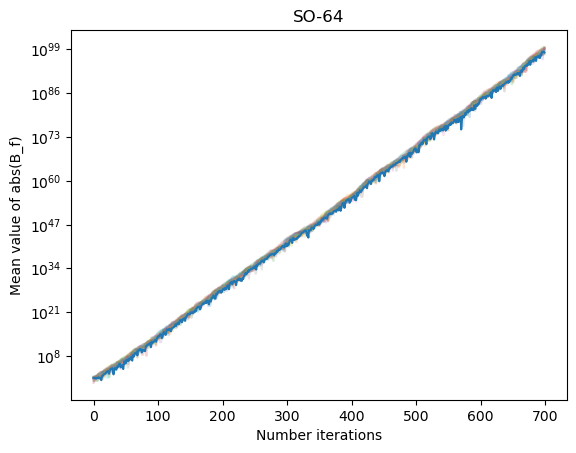

In [ ]:
plt.plot(np.arange(number_steps_sampler), np.abs(whole_chain_samples.mean(axis=(2))), alpha=.2)
plt.plot(np.arange(number_steps_sampler), np.abs(whole_chain_samples.mean(axis=(1,2))))
plt.yscale('log')
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Mean value of abs(B_f)')
plt.show()

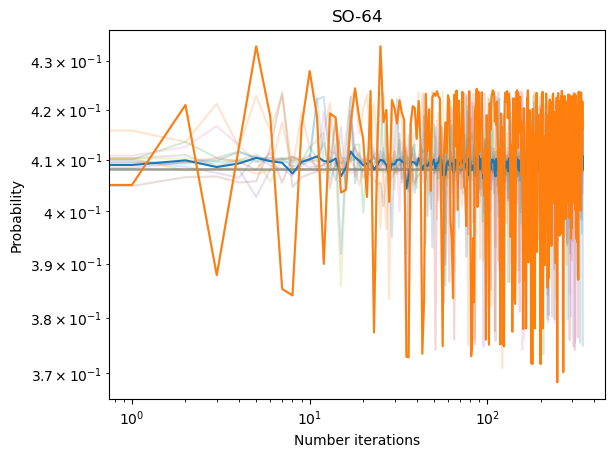

In [ ]:
log_prob_samples_reshape = log_prob_samples.reshape((n_walkers, int((number_steps_sampler-burnin)/thin)))

plt.plot(np.arange(int((number_steps_sampler-burnin)/thin)), np.exp(log_prob_samples_reshape.T), alpha=.2)
plt.plot(np.arange(int((number_steps_sampler-burnin)/thin)), np.mean(np.exp(log_prob_samples_reshape.T),axis=1))
plt.plot(np.arange(int((number_steps_sampler-burnin)/thin)), np.exp(log_prob_samples_reshape)[0])
plt.loglog()
plt.title(f"SO-{nside}")
plt.xlabel('Number iterations')
plt.ylabel('Probability')
plt.show()

In [ ]:
autocorr_time = sample_params_mixing_matrix_FG.get_autocorr_time()

print(autocorr_time.shape)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 6;
tau: [4.92166271 6.04822622 5.94470766 5.91877733 5.90582456 5.93614202
 5.83141322 5.92395121]

In [ ]:
cp_cp_noise = micmac.get_inv_BtinvNB(freq_inverse_noise, mixing_matrix_sampled)
cp_freq_inv_noise_sqrt = micmac.get_BtinvN(scipy.linalg.sqrtm(freq_inverse_noise), mixing_matrix_sampled)
cp_freq_inv_noise = micmac.get_BtinvN(freq_inverse_noise, mixing_matrix_sampled)

residual_post_sampling = input_cmb_maps[0] - np.einsum('kc,cf,fsp->ksp', cp_cp_noise, cp_freq_inv_noise, freq_maps)[0]

## Sample study

In [ ]:
ell_arange = np.arange(c_ells_input.shape[1])

In [ ]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-2
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)